# Training quantum embedding kernels for classification

In this tutorial we will dive deeper into the the concept of quantum embedding kernels, or quantum kernels. We will train a quantum kernel based on a similarity measure called the kernel-target alignment and see how the training improves the performance of it as a classifier. We will demonstrate how to use Covalent to orchestrate the whole workflow composed of multiple smaller subtasks. Once the workflow is dispatched, we will be able to track the results of each subtask through the Covalent result manager. In the meantime, all the subtasks constructed can be called as normal Python functions, giving users more flexibility in testing and debugging. For more details about the quantum embedding kernels, we refer the reader to this PennyLane demo: [Training and evaluating quantum kernels](https://pennylane.ai/qml/demos/tutorial_kernels_module.html#training-qeks), which this tutorial is based on.

In addition to Covalent, one first needs to install the following packages in order to fully reproduce the results of this tutorial.

In [1]:
with open("./requirements.txt", "r") as file:
    for line in file:
        print(line.rstrip())


covalent
matplotlib==3.5.1
pennylane==0.23.1
scikit-learn==1.1.1


In [2]:
# Install required packages
# !pip install -r ./requirements.txt


Let us begin by running `covalent start` in a terminal to start the Covalent server. Next we import the necessary packages.

In [3]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

np.random.seed(2022)


## Defining the quantum kernel

We first generate a dataset with two features and two classes for our classification task using `scikit-learn`'s `make_blobs` function. For this tutorial, we will make a toy dataset that contain 18 points as 9 "blobs", or clusters, arranged in a checkerboard fashion. We then do a train/test split of ratio 8:2. Moreover, we include the above two steps in the Covalent workflow as subtasks by adding the `electron` decorator on top of the respective functions.

In [4]:
@ct.electron
def get_data(n_samples=18):
    centers = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
    X, y = make_blobs(
        n_samples=n_samples, n_features=2, centers=centers, cluster_std=0.1, shuffle=False
    )
    # rescale labels to be -1, 1
    mapping = {0: -1, 1: 1, 2: -1, 3: 1, 4: -1, 5: 1, 6: -1, 7: 1, 8: -1}
    y = np.array([mapping[i] for i in y])
    X = X.astype(np.float32)
    y = y.astype(int)
    return X, y


@ct.electron
def split_train_test_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=3)
    return X_train, X_test, y_train, y_test


As mentioned in the beginning, these subtasks can be called as normal Python functions. So we can plot the dataset for visualization.

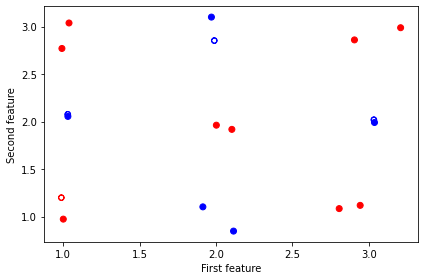

In [5]:
X, y = get_data()
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="w")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="$\u25EF$", cmap=cm_bright)
ax.set_xlabel("First feature")
ax.set_ylabel("Second feature")
plt.tight_layout()
plt.show()


Next, we construct the quantum embedding kernel by building a *data reuploading* quantum variational circuit based on the ansatz given in [Hubregtsen et al. 2021](https://arxiv.org/abs/2105.02276). Specifically, this ansatz uses a repeating layer architecture, where each layer embeds the 2 features into 5 qubits through the angles of $R_Z$ gates. The variational parameters correspond to the angles of a series of $R_Y$ and controlled-$R_Z$ gates. The ansatz diagram of one layer is shown below.

<div align="center">
<img src="assets/qek_circuit.png" style="width: 40%; height: 40%"/>
</div>

A quantum kernel is given by the mutual overlap of the two data-embedding quantum states, i.e.,
\begin{equation}
k(x_1, x_2) = \vert{\langle x_2, \boldsymbol{\theta} \vert x_1, \boldsymbol{\theta} \rangle} \vert^2,
\end{equation}
where $\boldsymbol{\theta}$ denotes the variational parameters. Therefore, to define a quantum kernel function, we construct the following subtasks with Covalent:

* `layer` - Build the quantum circuit for each layer based on the embedding ansatz given above.
* `ansatz` - Construct the full ansatz circuit with an arbitrary number of layers.
* `adjoint_ansatz` - Get the Hermitian adjoint of the ansatz circuit.
* `kernel_circuit` - Construct the quantum embedding kernel circuit from `ansatz` and `adjoint_ansatz`.
* `kernel` - Return the quantum kernel function based on `kernel_circuit`.

In [6]:
@ct.electron
def layer(x, params, wires, i0=0, inc=1):
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])


@ct.electron
def ansatz(x, params, wires):
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


@ct.electron
def adjoint_ansatz(ansatz):
    return qml.adjoint(ansatz)


@ct.electron
def kernel_circuit(params):
    dev = qml.device(
        "default.qubit", wires=params.shape[2], shots=None
    )  # number of wires corresponds to the third dimension of params
    wires = dev.wires.tolist()

    @qml.qnode(dev)
    def circuit(x1, x2, params):
        ansatz(x1, params, wires=wires)
        adjoint_ansatz(ansatz)(x2, params, wires=wires)
        return qml.probs(wires=wires)

    return circuit


@ct.electron
def kernel(x1, x2, params):
    return kernel_circuit(params)(x1, x2, params)[0]


Now we are in a position to build a support vector machine (SVM) classifier based on the quantum kernel and evaluate the accuracy of its predictions. It consists of three subtasks:

* `init_params` - Randomly initialize the variational parameters.
* `svm` - Build the SVM classifier using the quantum kernel.
* `get_accuracy` - Evaluate the accuracy of the classifier on a given dataset.

To accomplish the second subtask, we first use PennyLane's `qml.kernels.kernel_matrix` function to get the kernel matrix of a full dataset (not just between two data points) based on the given parameters. The kernel matrix is then fed into `scikit-learn`'s support vector classifier (`SVC`), which allows us to build a quantum SVM estimator using the training data.

In [7]:
@ct.electron
def init_params(num_wires, num_layers):
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)


@ct.electron
def svm(X, y, params):
    kernel_input = lambda x1, x2: kernel(x1, x2, params)
    svm = SVC(kernel=lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, kernel_input))
    svm.fit(X, y)
    return svm


@ct.electron
def calc_accuracy(classifier, X, y_true):
    return 1 - np.count_nonzero(classifier.predict(X) - y_true) / len(y_true)


Finally, we can bundle all the subtasks discussed above into a single workflow function called `init_qsvm` with the `lattice` decorator on top. This function will return the quantum SVM classifier based on randomly initialized parameters, the training/testing data along with their corresponding labels, and the training/testing accuracies. For this tutorial, we will be using 3 layers of the embedding ansatz.

In [8]:
@ct.lattice
def init_qsvm(n_samples=18, num_wires=5, num_layers=3):
    X, y = get_data(n_samples)
    X_train, X_test, y_train, y_test = split_train_test_data(X, y)
    params = init_params(num_wires, num_layers)
    classifier = svm(X_train, y_train, params)
    train_acc = calc_accuracy(classifier=classifier, X=X_train, y_true=y_train)
    test_acc = calc_accuracy(classifier=classifier, X=X_test, y_true=y_test)
    return classifier, X_train, y_train, X_test, y_test, train_acc, test_acc


The workflow is then dispatched to the Covalent server and the results are retrievable once the workflow is finished. One can also track all the results through the Covalent result manager at [http://localhost:48008](http://localhost:48008).

In [9]:
dispatch_id = ct.dispatch(init_qsvm)(18, 5, 3)
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
qsvm, X_train, y_train, X_test, y_test, train_acc, test_acc = result.result


In [10]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")


Train accuracy: 0.9285714285714286
Test accuracy: 0.75


Furthermore, we can also plot the decision boundaries of our initial SVM classifier for better visualization.

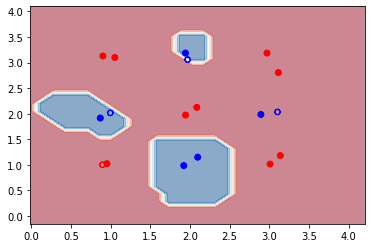

In [11]:
disp_init = DecisionBoundaryDisplay.from_estimator(
    qsvm, X, grid_resolution=30, response_method="predict", alpha=0.5, cmap=cm
)
disp_init.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
disp_init.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, marker="$\u25EF$")
plt.show()


We see that with a random set of parameters our initial SVM classifier performs pretty well on the small dataset used here. The accuracy is about 93% on the training set, while on the testing set it is 75%. However, it is clear from the decision-boundary plot that the classifier failed to correctly classify one of the clusters (labelled in blue). In the next section, we will train the quantum kernel to find a better set of parameters which will hopefully improve the accuracy of the classifier on both the training and testing datasets.

## Training the quantum kernel

The *kernel alignment* is a similarity measure between two kernels with kernel matrices $K_1$ and $K_2$, which is defined as
\begin{equation}
\text{KA}(K_1, K_2)\equiv \frac{\text{Tr}(K_1 K_2)}{\sqrt{\text{Tr}(K_1^2) \text{Tr}(K_2^2)}}.
\end{equation}
We will train the quantum SVM classifier by optimizing the *kernel-target alignment*, which compares the similarity predicted by the quantum kernel to the actual labels of the training data. In particular, any two training data points define an ideal kernel function given by
\begin{equation}
k_{\textbf{y}}(\textbf{x}_i, \textbf{x}_j) = y_i y_j,
\end{equation}
where $y_{i,j}$ are the labels associated with the data points $\textbf{x}_{i,j}$. The assigned kernel is thus $+1$ if both data points are in the same class and $-1$ if they belong to different classes. Then the kernel matrix is given by the outer product $\textbf{y}\textbf{y}^T$. The kernel-target alignment is therefore defined as the kernel alignment of the kernel matrix $K$ generated by the quantum kernel and the ideal kernel matrix $\textbf{y}\textbf{y}^T$:
\begin{equation}
\text{KTA}_{\textbf{y}}(K) = \frac{\text{Tr}(K_1 \textbf{y}\textbf{y}^T)}{\sqrt{\text{Tr}(K^2) \text{Tr}((\textbf{y}\textbf{y}^T)^2)}}.
\end{equation}
The training then aims to find an optimal set of variational parameters that maximizes the kernel-target alignment.

In the following, we will construct three subtasks as `electron` in Covalent for training the quantum embedding kernel:

* `target_alignment` - Compute the kernel-target alignment of the quantum kernel for a given labelled dataset.
* `get_optimizer` - Get the optimizer used for optimizing the kernel-target alignment. Here we choose the `AdagradOptimizer` from PennyLane.
* `training` - Train the quantum embedding kernel by optimizing the kernel-target alignment. During each training step, instead of optimizing based on all of the training data, we will use a random subset of the data with 5 data points to reduce the computational complexity.

In [12]:
@ct.electron
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


@ct.electron
def get_optimizer():
    return qml.AdagradOptimizer(0.4)


@ct.electron
def training(X, Y, init_params, opt, steps):
    params = init_params
    KTAs = []
    for i in range(steps):
        # Randomly choose subset of data points to compute the KTA on.
        subset = np.random.choice(list(range(len(X))), 5)
        # Define the cost function for optimization
        cost = lambda _params: -target_alignment(
            X[subset],
            Y[subset],
            lambda x1, x2: kernel(x1, x2, _params),
            assume_normalized_kernel=True,
        )
        # Optimization step
        params = opt.step(cost, params)
        KTAs.append(
            target_alignment(
                X, Y, lambda x1, x2: kernel(x1, x2, params), assume_normalized_kernel=True
            )
        )

    return params, KTAs


Similar to the previous case, we construct a full workflow called `trained_qsvm` by combining all the necessary subtasks for building a trained quantum SVM classifier. Note that we also track the kernel-target alignment at each training step through one of the returns `KTAs`. We will limit ourselves to 300 training steps in this demo. 

In [13]:
@ct.lattice
def trained_qsvm(n_samples=18, num_wires=5, num_layers=3, steps=300):
    X, y = get_data(n_samples)
    X_train, X_test, y_train, y_test = split_train_test_data(X, y)
    params = init_params(num_wires, num_layers)
    opt = get_optimizer()
    opt_params, KTAs = training(X_train, y_train, params, opt, steps)
    opt_classifier = svm(X_train, y_train, opt_params)
    train_acc = calc_accuracy(classifier=opt_classifier, X=X_train, y_true=y_train)
    test_acc = calc_accuracy(classifier=opt_classifier, X=X_test, y_true=y_test)
    return opt_classifier, KTAs, X_train, y_train, X_test, y_test, train_acc, test_acc


In [14]:
dispatch_id = ct.dispatch(trained_qsvm)(18, 5, 3, 300)
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
opt_qsvm, KTAs, X_train, y_train, X_test, y_test, train_acc, test_acc = result.result


This is what the full workflow in Covalent UI looks like:
<div align="center">
<img src="assets/qek_workflow.png" style="width: 95%; height: 95%"/>
</div>

Once the results are retrieved, we first take a look at the history of the kernel-target alignment. We can see that it increased from 0.2 to around 0.33 after 100 steps and more or less plateaued afterwards. This is a good sign that the training was working well.

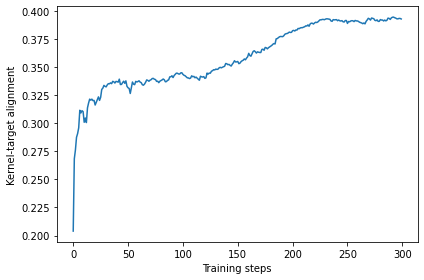

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="w")
ax.plot(KTAs)
ax.set_xlabel("Training steps")
ax.set_ylabel("Kernel-target alignment")
plt.tight_layout()
plt.show()


Again, let us display the accuracy of the trained quantum SVM classifier on the training and testing data. We then plot the decision boundaries below.

In [16]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")


Train accuracy: 1.0
Test accuracy: 1.0


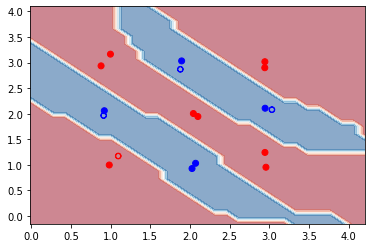

In [17]:
disp_trained = DecisionBoundaryDisplay.from_estimator(
    opt_qsvm, X, grid_resolution=30, response_method="predict", alpha=0.5, cmap=cm
)
disp_trained.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
disp_trained.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, marker="$\u25EF$")
plt.show()


We see that after training, the accuracy on both training and testing data has improved to 100%. From the decision boundaries, we also see that all the data points are now correctly classified. In this case, optimizing the kernel-target alignment indeed helps improve the performance of our quantum kernel! However, it should be noted that in general, having a high kernel-target alignment is only a necessary but not sufficient condition for good performance of a quantum kernel. The optimal alignment will not always bring the optimal kernel accuracy.

## Conclusion

In this tutorial we saw how to make use of Covalent for a quantum machine learning task, i.e., training a quantum kernel for a SVM classifier based on the kernel-target alignment. It is worth noting that for the toy problem given here, we were able to execute everything on our local machine in a reasonable amount of time. However, as the complexity of the problem increases, more hardware resources are demanded. In such cases, Covalent makes it easy to dispatch electrons or lattices to remote or cloud devices such as high performance computing (HPC) clusters. For more information, please refer to the following Covalent plugins for interfacing with advanced computing hardwares: [Slurm plugin](https://github.com/AgnostiqHQ/covalent-slurm-plugin) and [SSH plugin](https://github.com/AgnostiqHQ/covalent-ssh-plugin).